- wandb 쓰기
- 앙상블 하기
- 

In [1]:
!wandb login

wandb: Currently logged in as: ben8169. Use `wandb login --relogin` to force relogin


In [88]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [87]:
sizes = {
    'b0': (224, 224), 'b1': (256, 240), 'b2': (288, 288), 'b3': (320, 300),
    'b4': (384, 380), 'b5': (489, 456), 'b6': (561, 528), 'b7': (633, 600),
}
resolution = sizes['b0']
trial = '9'
resolution, trial

((224, 224), '9')

In [4]:
import wandb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 로드
# df = pd.read_csv('/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train.csv')
df = pd.read_csv('./skku-2024-1-machine-learning-third-project/train.csv')

# train-test 분리
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [5]:
df.shape

(3785, 2)

In [6]:
# df2 = pd.read_csv("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/test.csv")
df2 = pd.read_csv("skku-2024-1-machine-learning-third-project/test.csv")
df2

,image_name
0,6417.jpg
1,6418.jpg
2,6420.jpg
3,6422.jpg
4,6425.jpg
...,...
435,7132.jpg
436,7134.jpg
437,7135.jpg
438,7136.jpg


In [7]:
# import os
# import shutil

# dir = r"/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/SceneImages"

# # train_lst = df['image_name'].values.tolist()

# # for i in train_lst:
# #     shutil.move(dir+"/"+i,"/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train")

# # files = os.listdir(dir)
# # for i in (files):
# #     shutil.move(dir+"/"+i,"/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/test")

# print(len(os.listdir("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train")))
# print(len(os.listdir("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/test")))
# print(len(os.listdir("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/SceneImages")))

In [8]:
# print(set(os.listdir("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train")) == set(df['image_name'].values.tolist()))
# print(set(os.listdir("/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/test")) == set(df2['image_name'].values.tolist()))

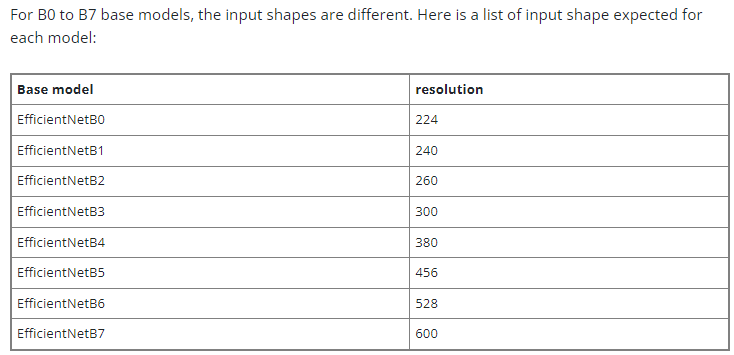

https://discuss.pytorch.org/t/input-size-for-efficientnet-versions-from-torchvision-models/140525

In [58]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image


class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# 이미지 변환 설정

def return_transforms(model):
    if model == inception:
        resolution = (299,299)
    else:
        resolution = (224,224)
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomResizedCrop(size=resolution, scale=(0.6, 1.0)),  # 더 넓은 스케일 범위
        transforms.RandomRotation(degrees=30),  # 더 큰 회전 각도
        # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),  # 더 강한 컬러 증강
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # 원근 변환 추가
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # 가우시안 블러 추가
    ])


    # train_dataset = CustomDataset(train_df, '/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train', transform=transform)
    # val_dataset = CustomDataset(val_df, '/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/train', transform=transform)
    train_dataset = CustomDataset(train_df, 'skku-2024-1-machine-learning-third-project/train', transform=transform)
    val_dataset = CustomDataset(val_df, 'skku-2024-1-machine-learning-third-project/train', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    return train_loader, val_loader


여기까지

In [10]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import models

# # 모델 정의
# model = models.efficientnet_b4(pretrained=True)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_df['label'].unique()))

# # GPU 사용 설정
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)


In [11]:
# project_name = 'b4_resoultion_changed'

# model_save_path = project_name+'.pth'
# df_save_path = './skku-2024-1-machine-learning-third-project/' + project_name + '.csv'
# model_save_path, df_save_path

In [12]:
# import os

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# # 학습 함수 정의
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=200):
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         running_corrects = 0

#         for inputs, labels in train_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(train_loader.dataset)
#         epoch_acc = running_corrects.double() / len(train_loader.dataset)

#         model.eval()
#         val_running_corrects = 0

#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)

#                 val_running_corrects += torch.sum(preds == labels.data)

#         val_acc = val_running_corrects.double() / len(val_loader.dataset)

#         print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}')

#         if val_acc >= best_acc:
#             best_acc = val_acc
#             # torch.save(model.state_dict(), '/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/best_model_200_twoaug.pth')
#             torch.save(model.state_dict(), model_save_path)

#     print('Best Val Acc: {:4f}'.format(best_acc))

# # 모델 학습
# train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)


In [13]:
# import pandas as pd
# import os
# from PIL import Image
# from torchvision import transforms


# # 모델 로드
# # model.load_state_dict(torch.load('/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/best_model_200_twoaug.pth'))
# model.load_state_dict(torch.load(model_save_path))
# model.eval()

# # 이미지 변환 설정
# transform = transforms.Compose([
#     transforms.Resize(resoultion),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# def predict_image(image_path, model):
#     image = Image.open(image_path).convert('RGB')
#     image = transform(image).unsqueeze(0).to(device)

#     with torch.no_grad():
#         outputs = model(image)
#         _, preds = torch.max(outputs, 1)

#     return preds.item()

# # 예측할 이미지 리스트 생성
# image_names = df2['image_name'].values.tolist()

# # 예측 결과 저장을 위한 리스트
# results = []

# # 예측 및 결과 저장
# for image_name in image_names:
#     image_path = os.path.join('./skku-2024-1-machine-learning-third-project/test', image_name)
#     predicted_class = predict_image(image_path, model)
#     results.append({'image_name': image_name, 'label': predicted_class})

# # 리스트를 데이터프레임으로 변환
# result_df = pd.DataFrame(results)

# # 결과 CSV 파일로 저장
# # result_df.to_csv('/content/drive/MyDrive/skku-2024-1-machine-learning-third-project/predictions_200.csv', index=False)
# result_df.to_csv(df_save_path, index=False)

# print(df_save_path)


In [14]:
# result_df

Ensemble

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

effnet = models.efficientnet_b0(pretrained=True)
resnet = models.resnet50(pretrained=True)
densenet = models.densenet121(pretrained=True)
inception = models.inception_v3(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)


# # Modify the models to suit our classification task
num_classes = 6
# dropout_rate = 0.35
# effnet.classifier[1] = nn.Sequential(
#             nn.Dropout(p=dropout_rate),
#             nn.Linear(effnet.classifier[1].in_features, num_classes) 
#         )

# resnet.fc = nn.Sequential(
#             nn.Dropout(p=dropout_rate),
#             nn.Linear(resnet.fc.in_features, num_classes) 
#         )

# densenet.classifier = nn.Sequential(
#             nn.Dropout(p=dropout_rate),
#             nn.Linear(densenet.classifier.in_features, num_classes)  
#         )

effnet.classifier[1] = torch.nn.Linear(effnet.classifier[1].in_features, num_classes)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, num_classes)
inception.AuxLogits.fc = torch.nn.Linear(inception.AuxLogits.fc.in_features, num_classes)
inception.fc = torch.nn.Linear(inception.fc.in_features, num_classes)
mobilenet.classifier[1] = torch.nn.Linear(mobilenet.classifier[1].in_features, num_classes)


# class DinoClassifier(torch.nn.Module):
#     def __init__(self, dino, num_classes):
#         super(DinoClassifier, self).__init__()
#         self.dino = dino
#         self.fc = torch.nn.Linear(dino.embed_dim, num_classes)
        
#     def forward(self, x):
#         x = self.dino(x)
#         x = self.fc(x)
#         return x

# dino_classifier = DinoClassifier(dino, num_classes)

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
effnet.to(device)
resnet.to(device)
densenet.to(device)
inception.to(device)
mobilenet.to(device)
print(device)

c:\Users\ben81\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ben81\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ben81\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get t

cuda


In [80]:
import torch
import torch.nn as nn
import torch.optim as optim

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = 0
        self.delta = delta

    def __call__(self, val_acc, model, model_name):
        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model, model_name)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model, model_name)
            self.counter = 0

    def save_checkpoint(self, val_acc, model, model_name):
        '''Saves model when validation accuracy increase.'''
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        if model_name == 'effnet':
            print(f'current model:{model_name}')
            torch.save(model.state_dict(), './skku-2024-1-machine-learning-third-project/models/eff'+ trial +'.pth')
        elif model_name == 'resnet':
            print(f'current model:{model_name}')
            torch.save(model.state_dict(), './skku-2024-1-machine-learning-third-project/models/res'+ trial +'.pth')
        elif model_name == 'densenet':
            print(f'current model:{model_name}')
            torch.save(model.state_dict(), './skku-2024-1-machine-learning-third-project/models/den'+ trial +'.pth')
        elif model_name == 'inception':
            print(f'current model:{model_name}')
            torch.save(model.state_dict(), './skku-2024-1-machine-learning-third-project/models/inc'+ trial +'.pth')
        elif model_name == 'mobilenet':
            print(f'current model:{model_name}')
            torch.save(model.state_dict(), './skku-2024-1-machine-learning-third-project/models/mob'+ trial +'.pth')
        else:
            print("=============Model Wrong Save=================")
        self.val_acc_max = val_acc


In [89]:
import torch
import wandb
import os

# Initialize wandb
# wandb.init(project="Third Project")
# wandb.run.name = 'ensemble' + trial
# wandb.run.name = 'mobilenet'
# wandb.run.save()

def train_model(model, criterion, optimizer, model_name, num_epochs=100, patience=20):
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        train_loader, val_loader = return_transforms(model)

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        model.eval()
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)

        print(f'Epoch {epoch+1 }/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}')
        # wandb.log({"epoch": epoch + 1, "loss": epoch_loss, "Accuracy": epoch_acc, "Val Acc": val_acc})

        if epoch >15: 
            early_stopping(val_acc, model, model_name)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    print('Best Val Acc: {:4f}'.format(early_stopping.val_acc_max))
    if model_name == 'effnet':
        model.load_state_dict(torch.load('./skku-2024-1-machine-learning-third-project/models/eff'+ trial +'.pth'))
    elif model_name == 'resnet':
        model.load_state_dict(torch.load('./skku-2024-1-machine-learning-third-project/models/res'+ trial +'.pth'))
    elif model_name == 'densenet':
        model.load_state_dict(torch.load('./skku-2024-1-machine-learning-third-project/models/den'+ trial +'.pth'))
    elif model_name == 'inception':
        model.load_state_dict(torch.load('./skku-2024-1-machine-learning-third-project/models/inc'+ trial +'.pth'))
    elif model_name == 'mobilenet':
        model.load_state_dict(torch.load('./skku-2024-1-machine-learning-third-project/models/mob'+ trial +'.pth'))
    return model


criterion = torch.nn.CrossEntropyLoss()
optimizer_effnet = torch.optim.Adam(effnet.parameters(), lr=1e-4)
optimizer_resnet = torch.optim.Adam(resnet.parameters(), lr=1e-4)
optimizer_densenet = torch.optim.Adam(densenet.parameters(), lr=1e-4)
optimizer_inception = torch.optim.Adam(inception.parameters(), lr=1e-4)
optimizer_mobilenet = torch.optim.Adam(mobilenet.parameters(), lr=1e-4)
optimizer_convnext = torch.optim.Adam(convnext.parameters(), lr=1e-4)



# inception = train_model(inception, criterion, optimizer_inception, 'inception',1)
mobilenet = train_model(mobilenet, criterion, optimizer_mobilenet, 'mobilenet')
# convnext = train_model(convnext, criterion, optimizer_convnext, 'convnext',1)
# effnet = train_model(effnet, train_loader, criterion, optimizer_effnet, 'effnet')
# resnet = train_model(resnet, train_loader, criterion, optimizer_resnet, 'resnet')
# densenet = train_model(densenet, train_loader, criterion, optimizer_densenet, 'densenet')

# Finish the wandb run
# wandb.finish()

Epoch 1/100, Loss: 0.6495, Acc: 0.7619, Val Acc: 0.8362
Epoch 2/100, Loss: 0.4125, Acc: 0.8524, Val Acc: 0.8547
Epoch 3/100, Loss: 0.3561, Acc: 0.8722, Val Acc: 0.8798
Epoch 4/100, Loss: 0.3488, Acc: 0.8722, Val Acc: 0.8520
Epoch 5/100, Loss: 0.3345, Acc: 0.8831, Val Acc: 0.8758
Epoch 6/100, Loss: 0.2782, Acc: 0.9003, Val Acc: 0.8613
Epoch 7/100, Loss: 0.2555, Acc: 0.9079, Val Acc: 0.8732
Epoch 8/100, Loss: 0.2314, Acc: 0.9122, Val Acc: 0.8705
Epoch 9/100, Loss: 0.2312, Acc: 0.9174, Val Acc: 0.8613
Epoch 10/100, Loss: 0.2141, Acc: 0.9240, Val Acc: 0.8771
Epoch 11/100, Loss: 0.2102, Acc: 0.9214, Val Acc: 0.8732
Epoch 12/100, Loss: 0.1967, Acc: 0.9343, Val Acc: 0.8719
Epoch 13/100, Loss: 0.1959, Acc: 0.9323, Val Acc: 0.8626
Epoch 14/100, Loss: 0.1796, Acc: 0.9320, Val Acc: 0.8719
Epoch 15/100, Loss: 0.1680, Acc: 0.9422, Val Acc: 0.8719
Epoch 16/100, Loss: 0.1516, Acc: 0.9472, Val Acc: 0.8745
Epoch 17/100, Loss: 0.1399, Acc: 0.9485, Val Acc: 0.8758
Validation accuracy increased (0.000000 

In [ ]:
effnet_v2 = models.efficientnet_b1(pretrained=False)
num_classes = 6
effnet_v2.classifier[1] = torch.nn.Linear(effnet_v2.classifier[1].in_features, num_classes)
effnet_v2.load_state_dict(torch.load('./skku-2024-1-machine-learning-third-project/models/eff6.pth'))
effnet_v2.eval() 
effnet_v2.to(device)



AttributeError: 'list' object has no attribute 'efficientnet_b1'

In [43]:
# Function to get soft voting ensemble predictions
def soft_voting_ensemble_predict(models, inputs):
    outputs = [torch.nn.functional.softmax(model(inputs), dim=1) for model in models]
    avg_output = sum(outputs) / len(outputs)
    return avg_output

# Evaluate the ensemble model using soft voting
# models = [effnet, resnet, densenet, inception, mobilenet]
models = [effnet_v2]
correct = 0
total = 0

for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = soft_voting_ensemble_predict(models, inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Ensemble Model Validation Accuracy with Soft Voting: {accuracy:.2f}%")


Ensemble Model Validation Accuracy with Soft Voting: 88.64%


In [ ]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
import torch

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # 모델 로드 함수
# def load_model(model_path):
#     model.load_state_dict(torch.load(model_path))
#     model = model.to(device)
#     model.eval()
#     return model

# model_paths = [
#     './skku-2024-1-machine-learning-third-project/models/eff.pth',
#     './skku-2024-1-machine-learning-third-project/models/res.pth',
#     './skku-2024-1-machine-learning-third-project/models/den.pth'
# ]


# effnet_b2.load_state_dict(torch.load('./skku-2024-1-machine-learning-third-project/models/eff.pth'))
# effnet_b2 = effnet_b2.to(device)
# effnet_b2.eval()

# resnet50.load_state_dict(torch.load('./skku-2024-1-machine-learning-third-project/models/eff.pth'))
# resnet50 = resnet50.to(device)
# resnet50.eval()

# densenet.load_state_dict(torch.load('./skku-2024-1-machine-learning-third-project/models/eff.pth'))
# densenet = densenet.to(device)
# densenet.eval()

models = [effnet, resnet, densenet, inception, mobilenet]

# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize(resolution),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def soft_voting_ensemble_predict(models, image):
    outputs = [torch.nn.functional.softmax(model(image), dim=1) for model in models]
    avg_output = sum(outputs) / len(outputs)
    return avg_output

def predict_image(image_path, models):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = soft_voting_ensemble_predict(models, image)
        _, preds = torch.max(outputs, 1)

    return preds.item()

# 예측할 이미지 리스트 생성
image_names = df2['image_name'].values.tolist()

# 예측 결과 저장을 위한 리스트
results = []

# 예측 및 결과 저장
for image_name in image_names:
    image_path = os.path.join('./skku-2024-1-machine-learning-third-project/test', image_name)
    predicted_class = predict_image(image_path, models)
    results.append({'image_name': image_name, 'label': predicted_class})

# 리스트를 데이터프레임으로 변환
result_df = pd.DataFrame(results)

# # 결과 CSV 파일로 저장
# result_df.to_csv('./skku-2024-1-machine-learning-third-project/ensemble_effb0resdense.csv', index=False)

# print('./skku-2024-1-machine-learning-third-project/ensemble_effb0resdense.csv')


In [ ]:
result_df

,image_name,label
0,6417.jpg,0
1,6418.jpg,3
2,6420.jpg,0
3,6422.jpg,2
4,6425.jpg,5
...,...,...
435,7132.jpg,5
436,7134.jpg,4
437,7135.jpg,1
438,7136.jpg,4


In [ ]:
result_df.to_csv('./skku-2024-1-machine-learning-third-project/ensemble_final_' + trial + 'th.csv', index=False)

print('./skku-2024-1-machine-learning-third-project/ensemble_final_' + trial + 'th.csv')

./skku-2024-1-machine-learning-third-project/ensemble_final_7th.csv


##### Convnext 실험

In [82]:
from torchvision.models import convnext_tiny
convnext = convnext_tiny(pretrained=True)


c:\Users\ben81\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ben81\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [85]:
convnext.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
effnet.classifier[1] = torch.nn.Linear(effnet.classifier[1].in_features, num_classes)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, num_classes)

In [84]:
convnext

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [83]:
convnext.classifier[2] = torch.nn.Linear(convnext.classifier[2].in_features, num_classes)